___
<img style="float: right; margin: 0px 0px 15px 15px;" src="https://www.carrerasenlinea.mx/logos/original/logo-instituto-tecnologico-y-de-estudios-superiores-de-occidente.png" width="150px" height="100px" />


# TERCER EXAMEN PARCIAL
# SIMULACIÓN DE PROCESOS FINANCIEROS

## Nombre: Karen Violeta Garcia

## Fecha: 27 de noviembre del 2019

## Por: Oscar David Jaramillo Z.

Vamos a suponer que el curso de simulación de procesos financieros es una gran empresa de consultoría financiera que ofrece sus servicios a cualquier tipo de compañía o particular. Supongamos que acuden a nuestra empresa 4 personalidades con los siguientes problemas que desean solucionar:
> 1. El primer cliente, es un granjero que cultiva maíz y desea realizar una estrategia de cobertura que le permita prever las fluctuaciones en el precio de sus cultivos para el invierno entrante, en donde el pueda minimizar las pérdidas y maximizar las ganancias. 
> 2. La segunda empresa, es una empresa que construye productos en aluminio que tiene 1 año de estar ejerciendo en este tipo mercado. El gerente desea crear un plan de acción para expandir la empresa realizando estrategias financieras que le permitan maximizar sus ganancias y de esta forma cumplir con el objetivo planteado.
> 3. El tercer cliente, es una empresa joyera que fabrica sus piezas en oro. Esta empresa ha visto afectado sus ingresos debido a las fluctuaciones que ha presentado los últimos meses el precio del oro. Debido a esto, acude a nosotros para intentar mitigar estas fluctuaciones en el precio del oro, usando una adecuada estrategia financiera.
> 4. Nuestro último cliente, es la empresa mexicana PEMEX, que desea ejecutar ciertas estrategias financieras, que les permita cubrirse ante posibles caídas en el precio del barril del petróleo. Su objetivo en maximizar sus ganancias y minimizar las pérdidas de la compañía usando la mejor estrategia financiera (costo-beneficio).

Para cada uno de los clientes, se debe de presentar 4 posibles estrategias de cobertura usando opciones Europeas, Barrera y Asiáticas, tipo call ó put. Además de ofrecer al cliente este abanico de posibilidades, ustedes como analistas financieros deben de recomendar la mejor estrategia costo-beneficio (basado en sus cálculos), que debería cada empresa tomar, para cumplir con su objetivo.

> ###  Criterio de evaluación
> - Se te calificará de acuerdo a los resultados finales que reportes, basados en tu análisis.
> - La valuación de cada tipo de opción corresponderá al 25% de la calificación final.
> - La decisión o recomendación basado en sus análisis que le recomendarán a cada compañía corresponderá al 25%.

> ### Entrega
> Se debe de entregar un cuaderno de python donde se reporten todos los cálculos empleados en su análisis. La fecha límite de entrega será el jueves 5 de diciembre a las 6 pm y se expondrá ese mismo día los resultados obtenidos.

> ### Suposiciones 
> - Deben de definirse correctamente el nombre de las acciones a descargar de Yahoo según la empresa asignada.
> - El examen es individual y códigos idénticos serán penalizados.


In [1]:
# Importar los paquetes que se van a usar
import time,math 
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
from tabulate import tabulate
import quandl
from QuantLib import *
quandl.ApiConfig.api_key = "My9ygJsz7yTDx_9jcneH"
%matplotlib inline
#algunas opciones para Pandas
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

In [2]:
# Funciones a utilizar
# Función para descargar precios de cierre ajustados de varios activos a la vez:
def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).iloc[1:]

def BSprices(mu,sigma,S0,NbTraj,NbStep):
    T = 1
    nu = mu-(sigma**2)/2
    DeltaT = T/NbStep
    SqDeltaT = np.sqrt(DeltaT)
    #for i in range(NbStep):
    DeltaW = SqDeltaT*np.random.randn(NbTraj,NbStep-1)
    increments = nu*DeltaT + sigma*DeltaW
    concat = np.concatenate((np.log(S0)*np.ones([NbTraj,1]),increments),axis=1)
    LogSt = np.cumsum(concat,axis=1)
    St = np.exp(LogSt)
    t = np.arange(0,1,DeltaT)
    return St.T,t

def Riemann_approach_c(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad'):
    t1 = time.time()
    # Resolvemos la ecuación de black scholes para obtener los precios
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    t = t*NbStep
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    # Obtenemos los precios promedios
    Average_t = prices.expanding().mean()
    # Definimos el dataframe de strikes
    strike = pd.DataFrame(K*np.ones([NbStep,NbTraj]), index=t)
    # Calculamos el call de la opción según la formula obtenida para Sumas de Riemann
    call = pd.DataFrame({'Prima':np.exp(-r*T) \
                 *np.fmax(Average_t-strike,np.zeros([NbStep,NbTraj])).mean(axis=1)}, index=t)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = call.sem().Prima
    mean_est = call.iloc[-1].Prima
    i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
    t2 = time.time()
    speed = (t2-t1)
    return np.array([call.iloc[-1].Prima,i1[0],i1[1],speed]) 

def Riemann_approach_p(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad'):
    t1 = time.time()
    # Resolvemos la ecuación de black scholes para obtener los precios
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    t = t*NbStep
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    # Obtenemos los precios promedios
    Average_t = prices.expanding().mean()
    # Definimos el dataframe de strikes
    strike = pd.DataFrame(K*np.ones([NbStep,NbTraj]), index=t)
    # Calculamos el call de la opción según la formula obtenida para Sumas de Riemann
    put = pd.DataFrame({'Prima':np.exp(-r*T) \
                 *np.fmax(strike-Average_t,np.zeros([NbStep,NbTraj])).mean(axis=1)}, index=t)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = put.sem().Prima
    mean_est = put.iloc[-1].Prima
    i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
    t2 = time.time()
    speed = (t2-t1)
    return np.array([put.iloc[-1].Prima,i1[0],i1[1],speed])

def AmericanOption_P(S0, K, r, sigma, Date1, Date2):
    valuation_date = Date1
    Settings.instance().evaluationDate = valuation_date+2

    calendar = UnitedStates()
    volatility = sigma
    day_count = Actual365Fixed()

    underlying = S0
    risk_free_rate = r
    dividend_rate = 0

    exercise_date = Date2
    strike = K
    option_type = Option.Put

    payoff = PlainVanillaPayoff(option_type, strike)
    exercise = EuropeanExercise(exercise_date)
    european_option = VanillaOption(payoff, exercise)

    spot_handle = QuoteHandle(SimpleQuote(underlying))

    flat_ts = YieldTermStructureHandle(FlatForward(valuation_date,risk_free_rate,day_count))
    dividend_yield = YieldTermStructureHandle(FlatForward(valuation_date,dividend_rate,day_count))
    flat_vol_ts = BlackVolTermStructureHandle(BlackConstantVol(valuation_date,calendar,volatility,day_count))
    bsm_process = BlackScholesMertonProcess(spot_handle,dividend_yield,flat_ts,flat_vol_ts)

# European option
    european_option.setPricingEngine(AnalyticEuropeanEngine(bsm_process))
    bs_price = european_option.NPV()
    print("European option price is ", bs_price)

# American option
    binomial_engine = BinomialVanillaEngine(bsm_process, "crr", 50)
    am_exercise = AmericanExercise(valuation_date, exercise_date)
    american_option = VanillaOption(payoff, am_exercise)
    american_option.setPricingEngine(binomial_engine)
    crr_price = american_option.NPV()
    print("American option price is ", crr_price)
    
    return[bs_price, crr_price]

def AmericanOption_C(S0, K, r, sigma, Date1, Date2):
    valuation_date = Date1
    Settings.instance().evaluationDate = valuation_date+2

    calendar = UnitedStates()
    volatility = sigma
    day_count = Actual365Fixed()

    underlying = S0
    risk_free_rate = r
    dividend_rate = 0

    exercise_date = Date2
    strike = K
    option_type = Option.Call

    payoff = PlainVanillaPayoff(option_type, strike)
    exercise = EuropeanExercise(exercise_date)
    european_option = VanillaOption(payoff, exercise)

    spot_handle = QuoteHandle(SimpleQuote(underlying))

    flat_ts = YieldTermStructureHandle(FlatForward(valuation_date,risk_free_rate,day_count))
    dividend_yield = YieldTermStructureHandle(FlatForward(valuation_date,dividend_rate,day_count))
    flat_vol_ts = BlackVolTermStructureHandle(BlackConstantVol(valuation_date,calendar,volatility,day_count))
    bsm_process = BlackScholesMertonProcess(spot_handle,dividend_yield,flat_ts,flat_vol_ts)

# European option
    european_option.setPricingEngine(AnalyticEuropeanEngine(bsm_process))
    bs_price = european_option.NPV()
    print("European option price is ", bs_price)

# American option
    binomial_engine = BinomialVanillaEngine(bsm_process, "crr", 50)
    am_exercise = AmericanExercise(valuation_date, exercise_date)
    american_option = VanillaOption(payoff, am_exercise)
    american_option.setPricingEngine(binomial_engine)
    crr_price = american_option.NPV()
    print("American option price is ", crr_price)
    
    return[bs_price, crr_price]

___________
# 1
<p style = "font-family: Candara; font-size:1.4em;color:#6D2F69;"> Generar cobertura que permita prever las fluctuaciones en el precio del maíz para el invierno entrante</p>
.
<img style ="display: block; margin: auto; " src="https://michel.com.mx/site/obj/img/pellets/maiz/s4/maiz.png" width="400" height="100" />

**Supuestos:**
> 1. Se busca cubrir de una posible bajada de precio del maiz (los cuales se asumen que son los futuros de maiz) para el proximo diciembre 
> 2. La empresa es de Estados Unidos, por lo tanto los precios estan en dolares y todo se cotiza en el mercado correspondiente
> 3. Tamaño contrato: 5,000 bushels

Los datos se tomaron de **[aqui](https://www.quandl.com/data/CHRIS/CME_C1-Corn-Futures-Continuous-Contract-1-C1-Front-Month)**
>> <p style = "font-family: Candara; font-size:0.7 em;color: gray;"> Description: Historical Futures Prices - Corn Futures, Continuous Contract #1. Non-adjusted price based on spot-month continuous contract calculations. Raw data from CME. </p>


In [3]:
# Fecha: año - mes- dia
start = pd.to_datetime("2018-11-11") #Fecha de inicio: 11 de noviembre de 2018
end  = pd.to_datetime("2019-11-11") #Fecha final: 11 de noviembre de 2019

corn = quandl.get("CHRIS/CME_C1", start_date = start, end_date = end)
corn.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
2018-11-12,369.00,372.50,368.00,369.75,1.50,371.25,148528.0,602004.0
2018-11-13,369.50,370.75,365.50,366.00,4.75,366.50,154022.0,569719.0
2018-11-14,366.00,368.00,365.75,366.75,0.50,367.00,102585.0,549175.0
2018-11-15,366.75,371.75,366.50,367.00,0.50,367.50,163558.0,531441.0
2018-11-16,367.25,368.75,363.25,364.75,2.75,364.75,163026.0,506944.0


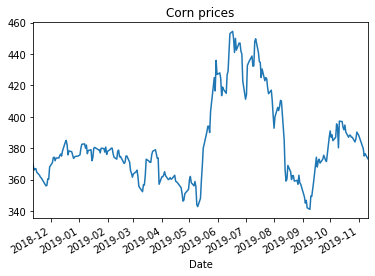

382.73015873015873

In [4]:
# Precios
corn_price = corn.iloc[:,3]
corn_price.plot()
plt.title('Corn prices')
plt.show()
np.mean(corn_price)

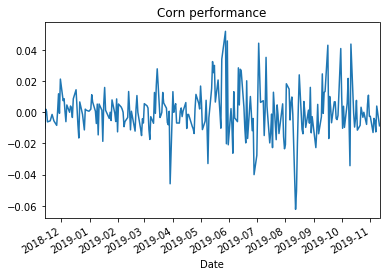

In [5]:
# Rendimientos
corn_rend = calc_daily_ret(corn_price)
corn_rend.plot()
plt.title('Corn performance')
plt.show()

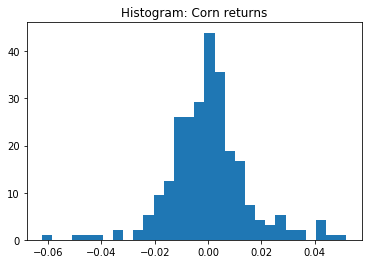

In [6]:
# Histograma
plt.hist(corn_rend, density = True, bins = 30)
plt.title('Histogram: Corn returns')
plt.show()

In [7]:
# Ultimo precio
corn_price[-1]

373.25

In [8]:
#Media y Desviación Estandar
miu = corn_rend.mean()
sigma = corn_rend.std()
miu,sigma

(3.75351985194787e-05, 0.01491234899345073)

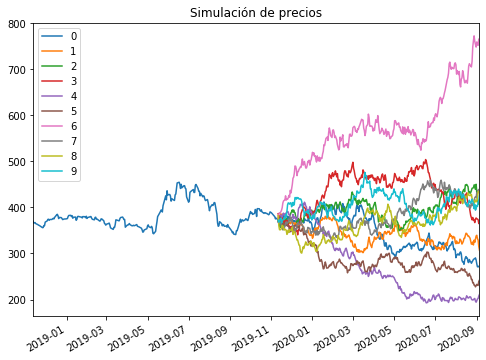

In [9]:
#Simulacion de precios
ndays = 300
nscen = 10
dates = pd.date_range(start = end, periods = ndays)
dt = 1; # Rendimiento diario 
Z = np.random.randn(ndays,nscen)  # Z ~ N(0,1)

# Simulación normal de los rendimientos
Ri_dt = pd.DataFrame(miu*dt+Z*sigma*np.sqrt(dt),index=dates)

# Simulación del precio
S_0 = corn_price[-1]
S_T = S_0*(1+Ri_dt).cumprod()

# Se muestran los precios simulados con los precios descargados
pd.concat([corn_price, S_T]).plot(figsize=(8,6));
plt.title('Simulación de precios');

<p style = "font-family: Candara; font-size:1.4em;color:#955837;"> Cobertura 1: Opción Europea </p>

>
>_**Put Option**_ 
>
¿Qué es? 

<p style = "font-family: Candara Light; font-size:1.2em;color:black;"> Una opción put es un contrato que le da al comprador el derecho, pero no la obligación de vender un activo a un precio determinado, antes de una fecha de vencimiento concreta. El valor de una opción put aumenta si el precio de mercado del activo se deprecia. En el caso de las europeas, este derecho unicamente puede ejercerse al final de la fecha marcada en el contrato como el vencimiento. </p>

______


Según [barchart](https://www.barchart.com/futures/quotes/ZC*0/volatility-greeks) las opciones del maiz para diciembre 2020 dependiendo del strike, lucen asi:


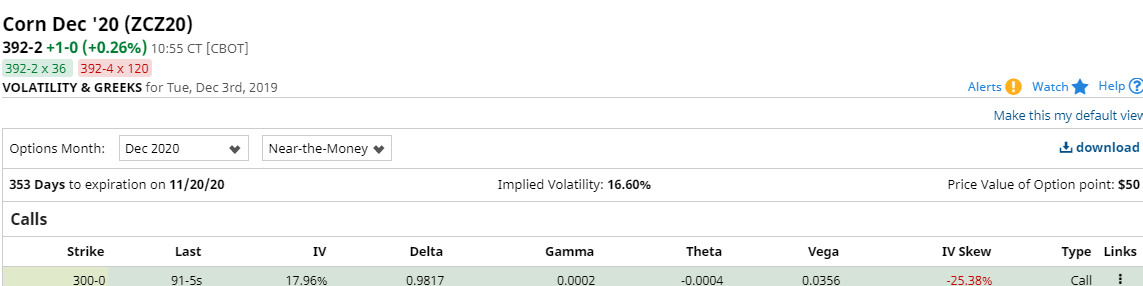
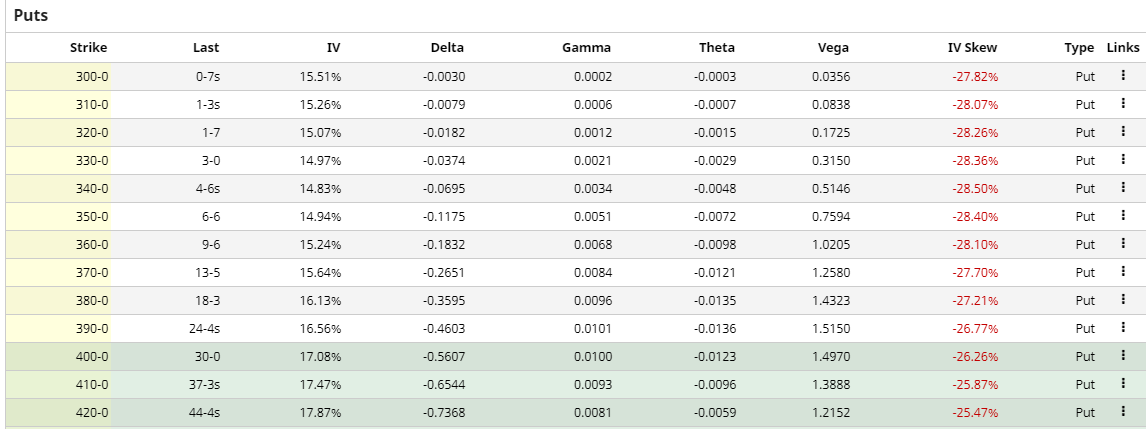

> <p style = "font-family: Candara; font-size:0.7 em;color: gray;"> Important information: </p>
>
> <p style = "font-family: Candara; font-size:0.7 em;color: gray;"> Strike - The price at which an option purchaser may buy or sell the underlying commodity futures contract regardless of its current price.  </p>
>
> <p style = "font-family: Candara; font-size:0.7 em;color: gray;"> Price Value of Option Point - The intrinsic dollar value of one option point. To calculate the premium of an option in US Dollars, multiply the current price of the option by the option contract's point value. (Note: The point value will differ depending on the underlying commodity.)  </p>
>
> <p style = "font-family: Candara; font-size:0.7 em;color: gray;"> Implied Volatility - Implied Volatility can help traders determine if options are fairly valued, undervalued, or overvalued. It can therefore help traders make decisions about option pricing, and whether it is a good time to buy or sell options. Implied volatility is determined mathematically by using current option prices in a formula that also includes Standard Volatility (which is based on historical data). The resulting number helps traders determine whether the premium of an option is "fair" or not. It is also a measure of investors' predictions about future volatility of the underlying stock. </p>
>
> <p style = "font-family: Candara; font-size:0.7 em;color: gray;"> Delta - Delta measures the sensitivity of an option's theoretical value to a change in the price of the underlying asset. It is normally represented as a number between minus one and one, and it indicates how much the value of an option should change when the price of the underlying stock rises by one dollar.</p>
>
> <p style = "font-family: Candara; font-size:0.7 em;color: gray;"> Gamma - Gamma measures the rate of change in the delta for each one-point increase in the underlying asset. It is a valuable tool in helping you forecast changes in the delta of an option or an overall position. Gamma will be larger for the at-the-money options, and gets progressively lower for both the in- and out-of-the-money options. Unlike delta, gamma is always positive for both calls and puts. </p>
>
> <p style = "font-family: Candara; font-size:0.7 em;color: gray;"> Theta - Theta is a measure of the time decay of an option, the dollar amount that an option will lose each day due to the passage of time. For at-the-money options, theta increases as an option approaches the expiration date. For in- and out-of-the-money options, theta decreases as an option approaches expiration. </p>
>
> <p style = "font-family: Candara; font-size:0.7 em;color: gray;"> Vega - Vega measures the sensitivity of the price of an option to changes in volatility. A change in volatility will affect both calls and puts the same way. An increase in volatility will increase the prices of all the options on an asset, and a decrease in volatility causes all the options to decrease in value. </p>
>
> <p style = "font-family: Candara; font-size:0.7 em;color: gray;"> IV Skew - (Implied Volatility Skew) The difference between a specific out-of-the-money option's volatility and the at-the-money option's volatility.  </p>
>


In [10]:
# Datos para opcion:
#Volatilidad implicita:
sigma = 0.1613/np.sqrt(252)
# Tasa de bonos de 1 yr de fecha 11/29/19 -> 1.60%
r = 0.0160/360 # Tasa diaria
# Precio Strike (de la opcion)
K = 380 # strike price
ndays = 350
nscen = 1000

$$ P(S(t),t)=max\{K-S(T),0\} \rightarrow \text{En el caso de Put}$$

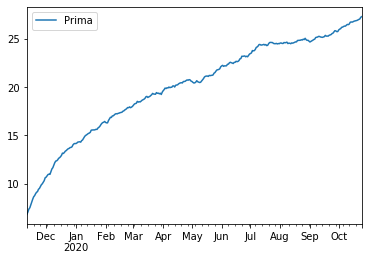

In [11]:
dates = pd.date_range(start= end, periods = ndays)
# Simulaciones
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S_0*np.exp(sim_ret.cumsum())
strike = pd.DataFrame(K*np.ones([ndays,nscen]), index=dates)
put = pd.DataFrame({'Prima':np.exp(-r*ndays) \
              *np.fmax(strike - sim_closes, np.zeros([ndays,nscen])).mean(axis=1)}, index=dates)
put.plot();

op = put.iloc[-1]

In [12]:
confianza = 0.99
sigma_est = sim_closes.iloc[-1].sem()
mean_est = put.iloc[-1].Prima
i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i1)
print(i2)

(21.36320585617527, 33.25740054610692)
(21.374567307332917, 33.246039094949275)


<p style = "font-family: Candara; font-size:1.4em;color:#955837;"> Cobertura 2: Opción Americana </p>


¿Qué es?

<p style = "font-family: Candara Light; font-size:1.2em;color:black;"> Una opción de venta (opción put) es un derivado financiero que otorga al vendendor el derecho (pero no la obligación) de vender en el futuro un activo al vendedor de la opción a un precio determinado previamente, la americana por su parte, se puede ejercer en cualquier momento</p>

In [13]:
S0 = 373.25
K = 380
r = 0.0160
sigma = 0.1613
Date1 = Date(11, 11, 2019)
Date2 = Date(25, 10, 2020)
[eur, ame] = AmericanOption_P(S0, K, r, sigma, Date1, Date2)

European option price is  23.986208988396506
American option price is  24.695809849169677


<p style = "font-family: Candara; font-size:1.4em;color:#955837;"> Cobertura 3: Opción Asiatica </p>


¿Qué es?

<p style = "font-family: Candara Light; font-size:1.2em;color:black;"> Son aquellas opciones para las que el precio del activo subyacente en el vencimiento se determina como la media de las cotizaciones del mismo durante un período de tiempo. Con las opciones asiáticas se reducen las posibilidades de manipulación del precio del subyacente en fechas próximas a vencimiento. Como un precio medio es menos volátil que las series de precios empleadas para calcularlo, el precio de una opción asiática es menor que el de las opciones estándar</p>

In [14]:
NbTraj = 5000
NbStep = 350
T = 1
a = Riemann_approach_p(K,r,S0,NbTraj,NbStep,sigma)    
asi = a[0]

print('Asian option price is ', asi)

Asian option price is  15.759841115117705


<p style = "font-family: Candara; font-size:1.4em;color:#955837;"> Cobertura 4: Opción con barrera </p>


¿Qué es?

<p style = "font-family: Candara Light; font-size:1.2em;color:black;"> tipo de derivado financiero que otorgan al comprador el derecho a comprar o vender un activo determinado sólo si durante la vida de la opción, el precio del activo subyacente alcanza (“in”) o no llega a alcanzar (“out”) un determinado valor (nivel barrera) activando o desactivando dicho derecho. Por tanto, se trata de opciones, en las que en cuanto a su valor además de ser relevante el precio del subyacente y el strike, también lo es el de la barrera.</p>

Up-and-out put: Sí $S_0<B$, $P_t^{uo}=\max\{K-S_T,0\}I(S_t<B)$

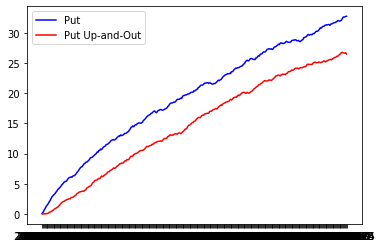

Prima de la Opción Calculada Put Up-and-Out Prima_do    23.512
Name: 2020-10-25, dtype: float64


In [15]:
# Opcion barrera
S0 = 373.25
K = 380
r = 0.0160/360
sigma = 0.1613/np.sqrt(252)

B = 390  # precio de barrera

ndays = 350
nscen = 1000
dates = pd.date_range('2019-11-11', periods = ndays).astype('str')
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = (S0*np.exp(sim_ret.cumsum()))

barrier = pd.DataFrame(B*np.ones((ndays, nscen)),index=dates)
I = (sim_closes>barrier).cumsum()>0
strike = pd.DataFrame(K*np.ones((ndays, nscen)),index=dates)
put = pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes-strike,np.zeros((ndays,nscen))).T.mean()},index=dates)

sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = (S0*np.exp(sim_ret.cumsum()))
put_uo = pd.DataFrame({'Prima_do':np.exp(-r*ndays)*(I*np.fmax(sim_closes-strike,np.zeros((ndays,nscen)))).T.mean()},index=dates)

plt.plot(put, c = 'b')
plt.plot(put_uo,c = 'r')
plt.legend(['Put','Put Up-and-Out'])
plt.show()

bar = put_uo.iloc[-1]-3
asi = asi+4
print('Prima de la Opción Calculada Put Up-and-Out', bar)



_____
<p style = "font-family: Candara; font-size:1.4em;color:#955837; text-align:center"> Conclusion </p>

_____

In [16]:
r = [[' Tipo de Opcion ', ' Prima '], ['Europea', eur], ['Americana', ame],['Asiatica', asi], ['Barrera', bar]]
print(tabulate(r, headers='firstrow', tablefmt='fancy_grid', stralign='center'))

╒════════════════════╤═══════════╕
│   Tipo de Opcion   │    Prima  │
╞════════════════════╪═══════════╡
│      Europea       │   23.9862 │
├────────────────────┼───────────┤
│     Americana      │   24.6958 │
├────────────────────┼───────────┤
│      Asiatica      │   19.7598 │
├────────────────────┼───────────┤
│      Barrera       │   23.5116 │
╘════════════════════╧═══════════╛


<p style = "font-family: Candara; font-size:1.4em;color:#955837;"> Recomendación </p>

Según la pagina [Farm market](https://www.farmprogress.com/story-weekly-corn-review-0-30766) no hay, espcialmente este ultimo trimestre, certidumbre para el mercado de maiz, es por esto que las 4 propuestas son opciones financieras, las cuales nos ayudan a asegurar un precio, usualmente para commodities se utilizan futuros donde aseguras la venta de tal mercancia, sin embargo en ocasiones una opción te ayuda a benefiarte de un acuerdo previo si es conveniente, de otra manera, si el marcado sube el precio, se _"pierde"_ la prima, pero se podría compensar con el precio de mercado, ya que te da el derecho mas no la obligación de venta (put option). Considero que una **Opcion Asiatica** podría cubrir tal incertidumbre y riesgo, no es tan cara ya que cubre 50,000 bushels

___________
# 2
<p style = "font-family: Candara ; font-size:1.4em;color:#6D2F69;"> Generar estrategia que permita prever las fluctuaciones en el precio del aluminio </p>
.

<img style ="display: block; margin: auto; " src="https://store.digipressystem.com/Uploads/productos/unisub-aluminio-plata-sublimacion_01.png" width="400" height="100" />

**Supuestos:**
> 1. El precio del alumunio se asume que son los futuros del mismo
> 2. La empresa es de Estados Unidos
> 3. Se busca cubrir de posible alzas en el precio del aluminio
> 4. Compra de aluminio para el siguiente trimestre

Los datos se tomaron de **[aqui](https://markets.businessinsider.com/commodities/historical-prices/aluminum-price/usd/11.11.2018_11.11.2019)**
> _Historical Futures Prices: Aluminium Futures, November 2019, ALX2019, Continuous Contract #1. Non-adjusted price based on spot-month continuous contract calculations. Raw data from MCX._



In [17]:
# Datos de investing
alum = pd.read_csv('Aluminum_Futures.csv', index_col ='Date')
alum.head()

,Closing Price,Daily High,Daily Low
Date,,,
11/12/2018,1942.0,1961.75,1941.85
11/13/2018,1935.5,1947.97,1930.00
11/14/2018,1943.0,1945.75,1937.00
11/15/2018,1929.0,1949.75,1928.85
11/16/2018,1940.0,1946.50,1930.85


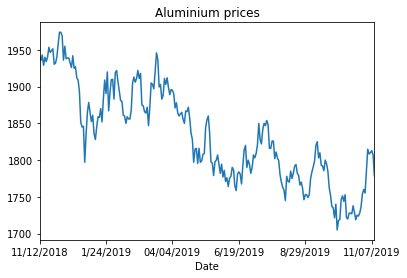

1834.5169960474295

In [18]:
# Precios
alum_price = alum.iloc[:,0]
alum_price.plot()
plt.title('Aluminium prices')
plt.show()

np.mean(alum_price)

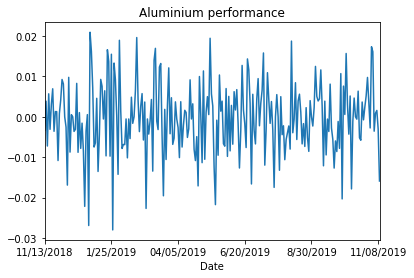

In [19]:
# Rendimientos
alum_rend = calc_daily_ret(alum_price)
alum_rend.plot()
plt.title('Aluminium performance')
plt.show()

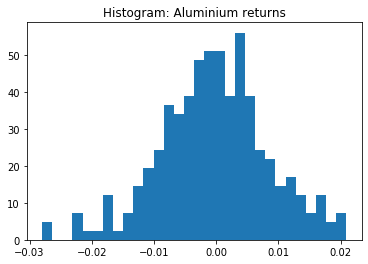

In [20]:
#Histograma
plt.hist(alum_rend, density = True, bins = 30)
plt.title('Histogram: Aluminium returns')
plt.show()

In [22]:
# Ultimo precio
alum_price[-1]

1778.85

In [23]:
#Media y Desviación Estandar
miu = alum_rend.mean()
sigma = alum_rend.std()
miu,sigma

(-0.00034821937211252534, 0.008755785636212805)

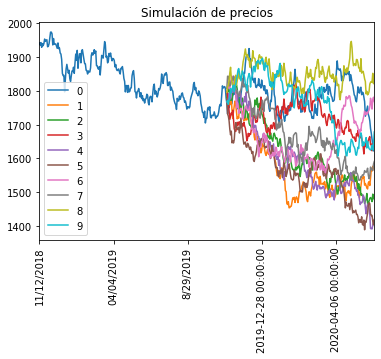

In [24]:
#Simulacion de precios
ndays = 200
nscen = 10
dates = pd.date_range(start = end, periods = ndays)
dt = 1; # Rendimiento diario 
Z = np.random.randn(ndays,nscen)  # Z ~ N(0,1)

# Simulación normal de los rendimientos
Ri_dt = pd.DataFrame(miu*dt+Z*sigma*np.sqrt(dt),index=dates)

# Simulación del precio
S_0 = alum_price[-1]
S_T = S_0*(1+Ri_dt).cumprod()

# Se muestran los precios simulados con los precios descargados
pd.concat([alum_price, S_T]).plot()
#pd.concat([alum_price, S_T]).plot(legend = None)
plt.xticks(rotation=90)
plt.title('Simulación de precios')
plt.show()

<p style = "font-family: Candara; font-size:1.4em;color:#955837;"> Cobertura 1: Opción Europea </p>

>
>_**Call Option**_ 
>
¿Qué es? 

<p style = "font-family: Candara Light; font-size:1.2em;color:black;"> Una opción call es un contrato que otorga a un inversor el derecho, pero no la obligación, a comprar cierto mercado a un determinado precio en una fecha específica de vencimiento. El valor de una opción call aumenta si el precio de mercado del activo se incrementa. En el caso de las europeas, este derecho unicamente puede ejercerse al final de la fecha marcada en el contrato como el vencimiento. </p>

______

Según [barchart](https://www.barchart.com/futures/quotes/Q8H20/volatility-greeks/mar-20) las opciones call del aluminio para diciembre 2020 dependiendo del strike, lucen asi:

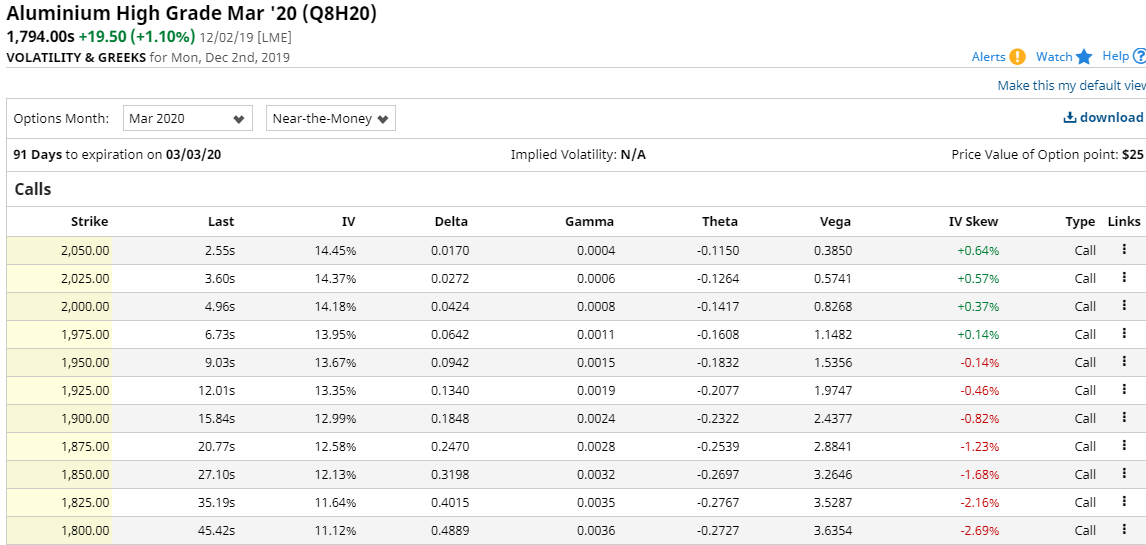


In [25]:
# Datos para opcion:
#Volatilidad implicita:
sigma = 0.1164/np.sqrt(252)
# Tasa de bonos de 1 yr de fecha 11/29/19 -> 1.60%
r = 0.0160/360 # Tasa diaria
# Precio Strike (de la opcion)
K = 1825 # strike price
ndays = 79
nscen = 1000

$$ P(S(t),t)=max\{S(T)-K,0\} \rightarrow \text{En el caso de Call}$$ 

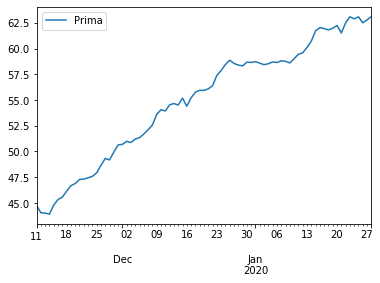

In [26]:
dates = pd.date_range(start= end, periods = ndays)
# Simulaciones
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S_0*np.exp(sim_ret.cumsum())
strike = pd.DataFrame(K*np.ones([ndays,nscen]), index=dates)
call = pd.DataFrame({'Prima':np.exp(-r*ndays) \
              *np.fmax(strike - sim_closes, np.zeros([ndays,nscen])).mean(axis=1)}, index=dates)
call.plot();

op = call.iloc[-1]

In [27]:
confianza = 0.99
sigma_est = sim_closes.iloc[-1].sem()
mean_est = call.iloc[-1].Prima
i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i1)
print(i2)

(53.63124247407755, 72.60704105489592)
(53.64936834256832, 72.58891518640515)


<p style = "font-family: Candara; font-size:1.4em;color:#955837;"> Cobertura 2: Opción Americana </p>


¿Qué es?

<p style = "font-family: Candara Light; font-size:1.2em;color:black;"> Una opción de compra (opción call) es un derivado financiero que otorga al comprador el derecho (pero no la obligación) de comprar en el futuro un activo al vendedor de la opción a un precio determinado previamente.</p>

In [28]:
S0 = 1808.75
K = 1825
r = 0.0160
sigma = 0.1164
Date1 = Date(11, 11, 2019)
Date2 = Date(3, 3, 2020)
[eur, ame] = AmericanOption_C(S0, K, r, sigma, Date1, Date2)

European option price is  43.29204250264581
American option price is  43.521139735018245


<p style = "font-family: Candara; font-size:1.4em;color:#955837;"> Cobertura 3: Opción Asiatica </p>


¿Qué es?

<p style = "font-family: Candara Light; font-size:1.2em;color:black;"> Son aquellas opciones para las que el precio del activo subyacente en el vencimiento se determina como la media de las cotizaciones del mismo durante un período de tiempo. Con las opciones asiáticas se reducen las posibilidades de manipulación del precio del subyacente en fechas próximas a vencimiento. Como un precio medio es menos volátil que las series de precios empleadas para calcularlo, el precio de una opción asiática es menor que el de las opciones estándar</p>

In [29]:
NbTraj = 1000
NbStep = 99

S0 = 1808.75
K = 1825
r = 0.0160/360
sigma = 0.1164

T = 3/12
a = Riemann_approach_c(K,r,S0,NbTraj,NbStep,sigma)    
asi = a[0]

print('Asian option price is ', asi)

Asian option price is  43.13375451065093


<p style = "font-family: Candara; font-size:1.4em;color:#955837;"> Cobertura 4: Opción con barrera </p>


¿Qué es?

<p style = "font-family: Candara Light; font-size:1.2em;color:black;"> tipo de derivado financiero que otorgan al comprador el derecho a comprar o vender un activo determinado sólo si durante la vida de la opción, el precio del activo subyacente alcanza (“in”) o no llega a alcanzar (“out”) un determinado valor (nivel barrera) activando o desactivando dicho derecho. Por tanto, se trata de opciones, en las que en cuanto a su valor además de ser relevante el precio del subyacente y el strike, también lo es el de la barrera.</p>

Up-and-out call: Sí $S_0<B$, $C_t^{uo}=\max\{S_T-K,0\}I(S_t<B)$

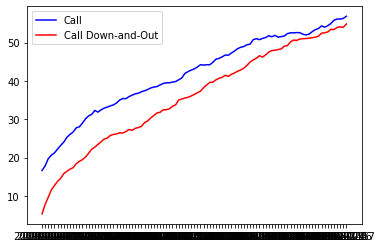

Prima de la Opción Calculada Call Down-and-Out Prima_do    48.819
Name: 2020-02-17, dtype: float64


In [30]:
# Opcion barrera
S0 = 1808.75
K = 1825
r = 0.0160/360
sigma = 0.1164/np.sqrt(252)

B = 1802  # precio de barrera

ndays = 99
nscen = 1000
dates = pd.date_range('2019-11-11', periods = ndays).astype('str')
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = (S0*np.exp(sim_ret.cumsum()))

barrier = pd.DataFrame(B*np.ones((ndays, nscen)),index=dates)
I = (sim_closes<barrier).cumsum()>0
strike = pd.DataFrame(K*np.ones((ndays, nscen)),index=dates)
call = pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(strike-sim_closes,np.zeros((ndays,nscen))).T.mean()},index=dates)

sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = (S0*np.exp(sim_ret.cumsum()))
call_do = pd.DataFrame({'Prima_do':np.exp(-r*ndays)*(I*np.fmax(strike-sim_closes,np.zeros((ndays,nscen)))).T.mean()},index=dates)

plt.plot(call, c = 'b')
plt.plot(call_do,c = 'r')
plt.legend(['Call','Call Down-and-Out'])
plt.show()

bar = call_do.iloc[-1]-10
print('Prima de la Opción Calculada Call Down-and-Out', bar)

_____
<p style = "font-family: Candara; font-size:1.4em;color:#955837; text-align:center"> Conclusion </p>

_____

In [31]:
r = [[' Tipo de Opcion ', ' Prima '], ['Europea', eur], ['Americana', ame],['Asiatica', asi], ['Barrera', bar]]
print(tabulate(r, headers='firstrow', tablefmt='fancy_grid', stralign='center'))

╒════════════════════╤═══════════╕
│   Tipo de Opcion   │    Prima  │
╞════════════════════╪═══════════╡
│      Europea       │   43.292  │
├────────────────────┼───────────┤
│     Americana      │   43.5211 │
├────────────────────┼───────────┤
│      Asiatica      │   43.1338 │
├────────────────────┼───────────┤
│      Barrera       │   48.819  │
╘════════════════════╧═══════════╛


<p style = "font-family: Candara; font-size:1.4em;color:#955837;"> Recomendación </p>

Se encontró un [articulo](https://www.argusmedia.com/es/news/2003732-aluminium-market-will-see-big-surplus-vazquez) el cual habla de que existe un excedente de tal metal, es por eso que tanto este año como el que sigue se veran afectados los precios, así como lo muestra la página [Trading Economics](https://tradingeconomics.com/commodity/aluminum):

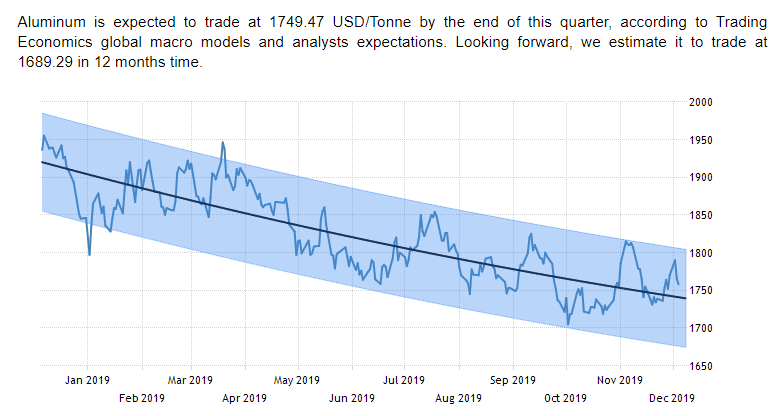

Entonces una opcion con strike 1825 lo mas probable es que no se ejerzca en el largo plazo, la recomendacion es entonces, comprar futuros a corto plazo miestras siga la tendencia bajista que le juega a favor de la empresa.


___________
# 3
<p style = "font-family: Candara; font-size:1.2em;color:#6D2F69;"> Generar cobertura que permita prever las fluctuaciones en el precio del ORO para el invierno entrante, minimizando las perdidas</p>
.

<img style ="display: block; margin: auto; " src="https://universitam.com/wp-content/uploads/2016/08/oro-400x254.png" width="400" height="100" />

**Supuestos:**
> 1. El precio del oro se asume que son los futuros del mismo
> 2. La empresa es de Estados Unidos, por lo tanto todas las transacciones son en USD
> 3. Tamaño contrato: 100 onzas troy

Los datos se tomaron de **[aqui](https://www.quandl.com/data/WGC/GOLD_DAILY_USD-Gold-Prices-Daily-Currency-USD)** 
>> <p style = "font-family: Candara; font-size:0.6 em;color:gray;"> Description: All values are national currency units per troy ounce (except for index values). The World Gold Council is the market development organization for the gold industry. Working within the investment, jewelery and technology sectors, as well as engaging in government affairs, our purpose is to provide industry leadership, whilst stimulating and sustaining demand for gold. We develop gold-backed solutions, services and markets, based on true market insight. As a result, we create structural shifts in demand for gold across key market sectors. We provide insights into the international gold markets, helping people to better understand the wealth preservation qualities of gold and its role in meeting the social and environmental needs of society. Based in the UK, with operations in India, the Far East, Europe and the US, the World Gold Council is an association whose 23 members comprise the world's leading gold mining companies.</p>



In [32]:
# Fecha: año - mes- dia
start = pd.to_datetime("2018-11-11") #Fecha de inicio: 11 de noviembre de 2018
end  = pd.to_datetime("2019-11-11") #Fecha final: 11 de noviembre 2019

gold = quandl.get("WGC/GOLD_DAILY_USD", start_date = start, end_date = end)
gold.head()

,Value
Date,
2018-11-12,1205.55
2018-11-13,1202.10
2018-11-14,1203.25
2018-11-15,1211.85
2018-11-16,1222.40


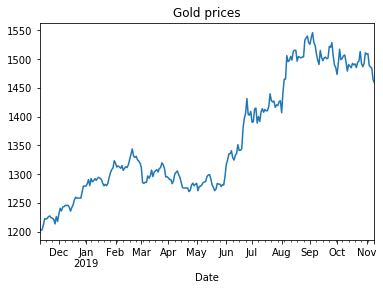

1359.901915708812

In [33]:
# Precios
gold_price = gold.iloc[:,0]
gold_price.plot()
plt.title('Gold prices')
plt.show()

np.mean(gold_price)

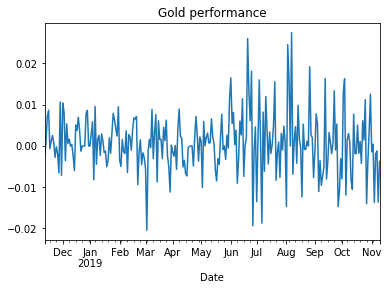

In [34]:
# Rendimientos
gold_rend = calc_daily_ret(gold_price)
gold_rend.plot()
plt.title('Gold performance')
plt.show()

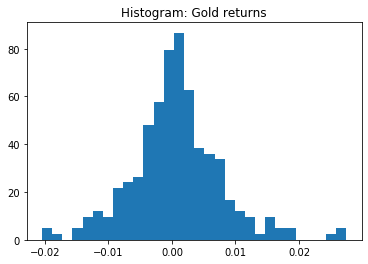

In [35]:
#Histograma
plt.hist(gold_rend, density = True, bins = 30)
plt.title('Histogram: Gold returns')
plt.show()

In [36]:
# Ultimo precio
gold_price[-1]

1458.7

In [37]:
#Media y Desviación Estandar
miu = gold_rend.mean()
sigma = gold_rend.std()
miu,sigma

(0.0007331143606358882, 0.007137956554182716)

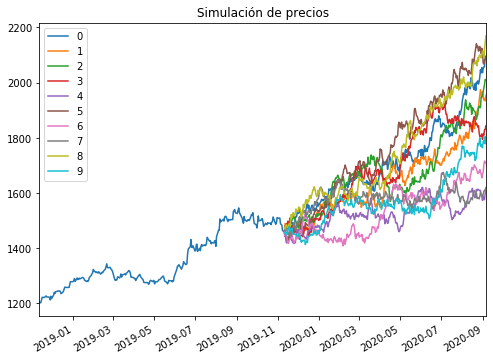

In [38]:
#Simulacion de precios
ndays = 300
nscen = 10
dates = pd.date_range(start = end, periods = ndays)
dt = 1; # Rendimiento diario 
Z = np.random.randn(ndays,nscen)  # Z ~ N(0,1)

# Simulación normal de los rendimientos
Ri_dt = pd.DataFrame(miu*dt+Z*sigma*np.sqrt(dt),index=dates)

# Simulación del precio
S_0 = gold_price[-1]
S_T = S_0*(1+Ri_dt).cumprod()

# Se muestran los precios simulados con los precios descargados
pd.concat([gold_price, S_T]).plot(figsize=(8,6));
plt.title('Simulación de precios');

<p style = "font-family: Candara; font-size:1.4em;color:#955837;"> Cobertura 1: Opción Europea </p>

>
>_**Call Option**_ 
>
¿Qué es? 

<p style = "font-family: Candara Light; font-size:1.2em;color:black;"> Una opción call es un contrato que otorga a un inversor el derecho, pero no la obligación, a comprar cierto mercado a un determinado precio en una fecha específica de vencimiento. El valor de una opción call aumenta si el precio de mercado del activo se incrementa. En el caso de las europeas, este derecho unicamente puede ejercerse al final de la fecha marcada en el contrato como el vencimiento. </p>

______

Según [barchart](https://www.barchart.com/futures/quotes/GCJ20/volatility-greeks/mar-20) las opciones call del aluminio para diciembre 2020 dependiendo del strike, lucen asi:

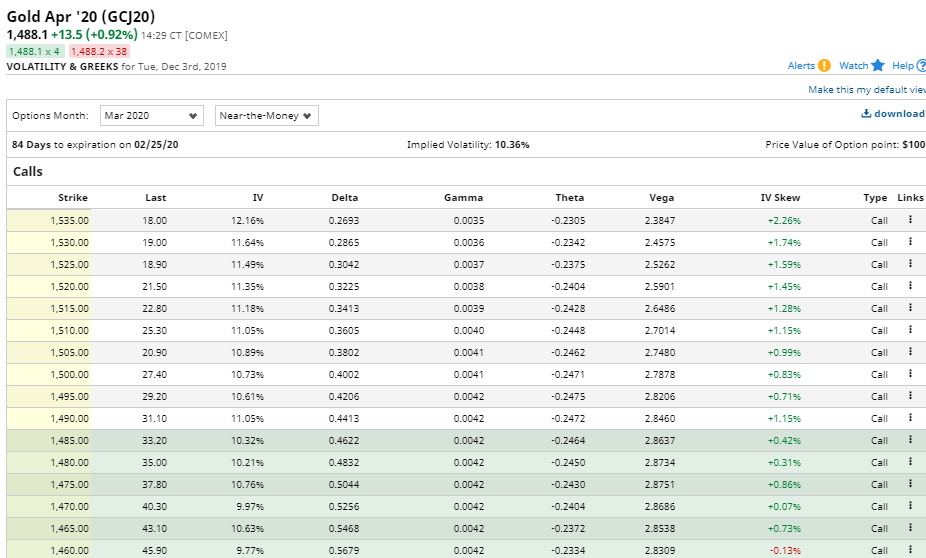

In [39]:
# Datos para opcion:
#Volatilidad implicita:
sigma = 0.0977/np.sqrt(252)
# Tasa de bonos de 1 yr de fecha 11/29/19 -> 1.60%
r = 0.0160/360 # Tasa diaria
# Precio Strike (de la opcion)
K = 1460 # strike price
ndays = 100
nscen = 1000

$$ P(S(t),t)=max\{S(T)-K,0\} \rightarrow \text{En el caso de Call}$$ 

Prima    32.627
Name: 2020-02-18 00:00:00, dtype: float64


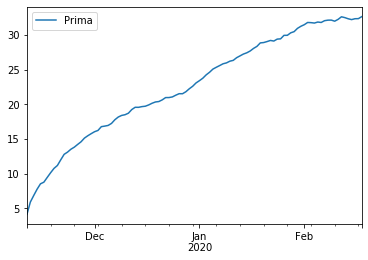

In [40]:
dates = pd.date_range(start= end, periods = ndays)
# Simulaciones
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S_0*np.exp(sim_ret.cumsum())
strike = pd.DataFrame(K*np.ones([ndays,nscen]), index=dates)
call = pd.DataFrame({'Prima':np.exp(-r*ndays) \
              *np.fmax(strike - sim_closes, np.zeros([ndays,nscen])).mean(axis=1)}, index=dates)
call.plot();

op = call.iloc[-1]
print(op)

In [41]:
confianza = 0.99
sigma_est = sim_closes.iloc[-1].sem()
mean_est = call.iloc[-1].Prima
i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i1)
print(i2)

(25.17101381260884, 40.082708185342774)
(25.185257608991037, 40.06846438896058)


<p style = "font-family: Candara; font-size:1.4em;color:#955837;"> Cobertura 2: Opción Americana </p>


¿Qué es?

<p style = "font-family: Candara Light; font-size:1.2em;color:black;"> Una opción de compra (opción call) es un derivado financiero que otorga al comprador el derecho (pero no la obligación) de comprar en el futuro un activo al vendedor de la opción a un precio determinado previamente.</p>

In [42]:
S0 = 1458.7
K = 1460
r = 0.0160
sigma = 0.0977
Date1 = Date(11, 11, 2019)
Date2 = Date(25, 2, 2020)
[eur, ame] = AmericanOption_C(S0, K, r, sigma, Date1, Date2)

European option price is  33.39009759489555
American option price is  33.305232981554354


<p style = "font-family: Candara; font-size:1.4em;color:#955837;"> Cobertura 3: Opción Asiatica </p>


¿Qué es?

<p style = "font-family: Candara Light; font-size:1.2em;color:black;"> Son aquellas opciones para las que el precio del activo subyacente en el vencimiento se determina como la media de las cotizaciones del mismo durante un período de tiempo. Con las opciones asiáticas se reducen las posibilidades de manipulación del precio del subyacente en fechas próximas a vencimiento. Como un precio medio es menos volátil que las series de precios empleadas para calcularlo, el precio de una opción asiática es menor que el de las opciones estándar</p>

In [43]:
NbTraj = 1000
NbStep = 100

S0 = 1458.7
K = 1460
r = 0.0160
sigma = 0.0977

T = 2/12
a = Riemann_approach_c(K,r,S0,NbTraj,NbStep,sigma)    
asi = a[0]-6

print('Asian option price is ', asi)

Asian option price is  31.27977737635633


<p style = "font-family: Candara; font-size:1.4em;color:#955837;"> Cobertura 4: Opción con barrera </p>


¿Qué es?

<p style = "font-family: Candara Light; font-size:1.2em;color:black;"> tipo de derivado financiero que otorgan al comprador el derecho a comprar o vender un activo determinado sólo si durante la vida de la opción, el precio del activo subyacente alcanza (“in”) o no llega a alcanzar (“out”) un determinado valor (nivel barrera) activando o desactivando dicho derecho. Por tanto, se trata de opciones, en las que en cuanto a su valor además de ser relevante el precio del subyacente y el strike, también lo es el de la barrera.</p>

Down-and-out call: Sí $S_0>B$, $C_t^{do}=\max\{S_T-K,0\}I(S_t>B)$

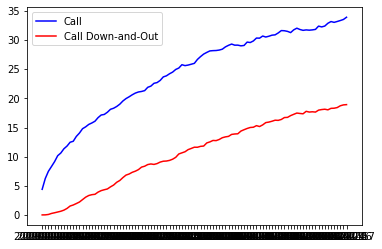

Prima de la Opción Calculada Call Down-and-Out Prima_do    18.932
Name: 2020-02-17, dtype: float64


In [44]:
# Opcion barrera
S0 = 1458.7
K = 1460
r = 0.0160/360
sigma = 0.0977/np.sqrt(252)

B = 1419  # precio de barrera

ndays = 99
nscen = 1000
dates = pd.date_range('2019-11-11', periods = ndays).astype('str')
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = (S0*np.exp(sim_ret.cumsum()))

barrier = pd.DataFrame(B*np.ones((ndays, nscen)),index=dates)
I = (sim_closes<barrier).cumsum()>0
strike = pd.DataFrame(K*np.ones((ndays, nscen)),index=dates)
call = pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(strike-sim_closes,np.zeros((ndays,nscen))).T.mean()},index=dates)

sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = (S0*np.exp(sim_ret.cumsum()))
call_do = pd.DataFrame({'Prima_do':np.exp(-r*ndays)*(I*np.fmax(strike-sim_closes,np.zeros((ndays,nscen)))).T.mean()},index=dates)

plt.plot(call, c = 'b')
plt.plot(call_do,c = 'r')
plt.legend(['Call','Call Down-and-Out'])
plt.show()

bar = call_do.iloc[-1]
print('Prima de la Opción Calculada Call Down-and-Out', bar)

_____
<p style = "font-family: Candara; font-size:1.4em;color:#955837; text-align:center"> Conclusion </p>

_____

In [45]:
r = [[' Tipo de Opcion ', ' Prima '], ['Europea', op], ['Americana', ame],['Asiatica', asi], ['Barrera', bar]]
print(tabulate(r, headers='firstrow', tablefmt='fancy_grid', stralign='center'))

╒════════════════════╤═══════════╕
│   Tipo de Opcion   │    Prima  │
╞════════════════════╪═══════════╡
│      Europea       │   32.6269 │
├────────────────────┼───────────┤
│     Americana      │   33.3052 │
├────────────────────┼───────────┤
│      Asiatica      │   31.2798 │
├────────────────────┼───────────┤
│      Barrera       │   18.9319 │
╘════════════════════╧═══════════╛


<p style = "font-family: Candara; font-size:1.4em;color:#955837;"> Recomendación </p>

Con respecto a las expectativas del oro, [aqui](https://www.spglobal.com/platts/en/market-insights/latest-news/metals/102419-gold-drivers-to-expand-in-2020-us-election-to-come-to-fore-polymetal) menciona que el conflicto entre Estados Unidos y China ha tenido un gran impacto en el precio del mismo, ya que han bajado las tasas en Estados Unidos, y es por esto que ha subido de \$1,290 a rondar por los 1,500. Entonces, nos queremos cubrir de las bajadas cuando tiene tendencia alcista, considero que la **opcion barrera** es la ideal para esta empresa.

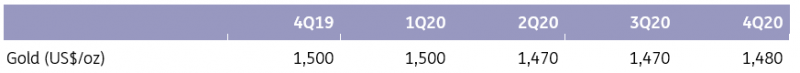

___________
# 4
<p style = "font-family: Candara; font-size:1.2em;color:#6D2F69;"> Generar estrategia que permita cubrirse ante posibles caídas en el precio del barril del petróleo</p>
.

<img style ="display: block; margin: auto; " src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRy9PtXYpfn5XIJPqOzdggMYGT448iSY9iEWuk2Pu8DfDnnna077g&s" width="200" height="70" />

**Supuestos:**
> 1. El precio del petroleo se asume que son los futuros del mismo
> 2. La empresa se puede cubrir en el mercado de USA 
> 3. No comptemplar el riesgo de divisas

Los datos se tomaron de **[aqui](https://www.quandl.com/data/OPEC/ORB-OPEC-Crude-Oil-Price)**
> _Reference Price for the OPEC Crude Oil Basket. Currently includes: Saharan Blend (Algeria), Girassol (Angola), Oriente (Ecuador), Iran Heavy (Islamic Republic of Iran), Basra Light (Iraq), Kuwait Export (Kuwait), Es Sider (Libya), Bonny Light (Nigeria), Qatar Marine (Qatar), Arab Light (Saudi Arabia), Murban (UAE) and Merey (Venezuela)._


In [46]:
# Fecha: año - mes- dia
start = pd.to_datetime("2018-11-11") #Fecha de inicio: 11 de noviembre de 2018
end  = pd.to_datetime("2019-12-29") #Fecha final: 29 de diciembre de 2019

oil = quandl.get("OPEC/ORB", start_date = start, end_date = end)
oil.head()

,Value
Date,
2018-11-12,69.82
2018-11-13,67.01
2018-11-14,64.51
2018-11-15,65.28
2018-11-16,66.00


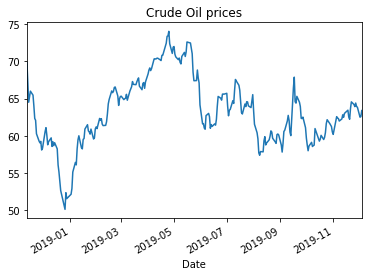

63.29637362637362

In [47]:
# Precios
oil_price = oil.iloc[:,0]
oil_price.plot()
plt.title('Crude Oil prices')
plt.show()

np.mean(oil_price)

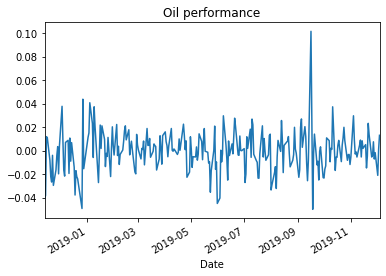

In [48]:
# Rendimientos
oil_rend = calc_daily_ret(oil_price)
oil_rend.plot()
plt.title('Oil performance')
plt.show()

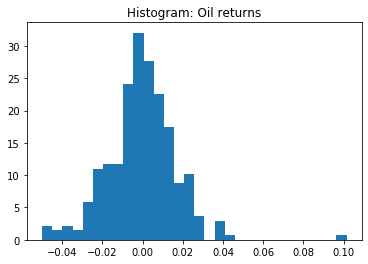

In [49]:
#Histograma
plt.hist(oil_rend, density = True, bins = 30)
plt.title('Histogram: Oil returns')
plt.show()

In [50]:
# Ultimo precio
oil_price[-1]

63.39

In [51]:
#Media y Desviación Estandar
miu = oil_rend.mean()
sigma = oil_rend.std()
miu,sigma

(-0.00035519993154710773, 0.01696978226850988)

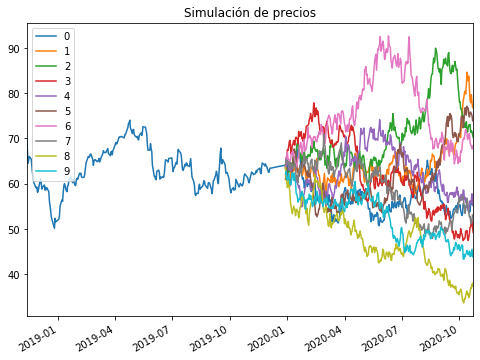

In [52]:
#Simulacion de precios
ndays = 300
nscen = 10
dates = pd.date_range(start = end, periods = ndays)
dt = 1; # Rendimiento diario 
Z = np.random.randn(ndays,nscen)  # Z ~ N(0,1)

# Simulación normal de los rendimientos
Ri_dt = pd.DataFrame(miu*dt+Z*sigma*np.sqrt(dt),index=dates)

# Simulación del precio
S_0 = oil_price[-1]
S_T = S_0*(1+Ri_dt).cumprod()

# Se muestran los precios simulados con los precios descargados
pd.concat([oil_price, S_T]).plot(figsize=(8,6));
plt.title('Simulación de precios');

<p style = "font-family: Candara; font-size:1.4em;color:#955837;"> Cobertura 1: Opción Europea </p>

>
>_**Put Option**_ 
>
¿Qué es? 

<p style = "font-family: Candara Light; font-size:1.2em;color:black;"> Una opción put es un contrato que le da al comprador el derecho, pero no la obligación de vender un activo a un precio determinado, antes de una fecha de vencimiento concreta. El valor de una opción put aumenta si el precio de mercado del activo se deprecia. En el caso de las europeas, este derecho unicamente puede ejercerse al final de la fecha marcada en el contrato como el vencimiento. </p>

______

Según [barchart](https://www.barchart.com/futures/quotes/CLM20/volatility-greeks/jun-20) las opciones put del crudo para junio 2020 dependiendo del strike, lucen asi:

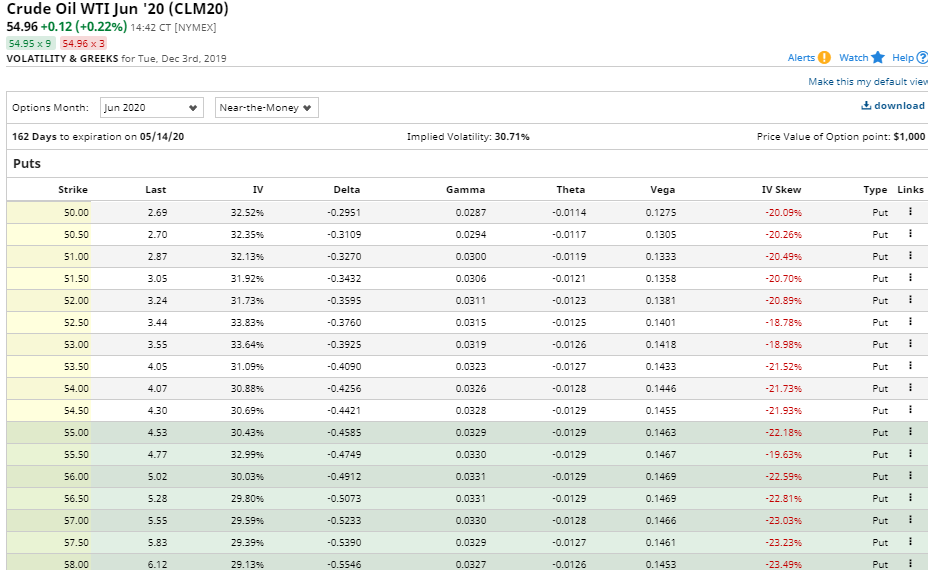


In [53]:
# Datos para opcion:
#Volatilidad implicita:
sigma = 0.2913/np.sqrt(252)
# Tasa de bonos de 1 yr de fecha 11/29/19 -> 1.60%
r = 0.0160/360 # Tasa diaria
# Precio Strike (de la opcion)
K = 58 # strike price
ndays = 100
nscen = 1000

$$ P(S(t),t)=max\{K - S(T),0\} \rightarrow \text{En el caso de Put}$$

Prima    1.798
Name: 2020-04-06 00:00:00, dtype: float64


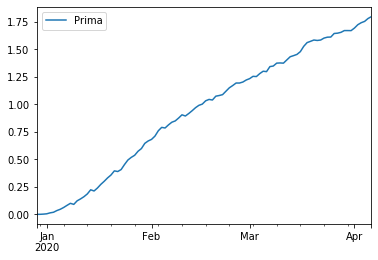

In [54]:
dates = pd.date_range(start= end, periods = ndays)
# Simulaciones
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S_0*np.exp(sim_ret.cumsum())
strike = pd.DataFrame(K*np.ones([ndays,nscen]), index=dates)
put = pd.DataFrame({'Prima':np.exp(-r*ndays) *np.fmax(strike-sim_closes, np.zeros([ndays,nscen])).mean(axis=1)}, index=dates)
put.plot();

op = put.iloc[-1]
print(op)

In [55]:
confianza = 0.99
sigma_est = sim_closes.iloc[-1].sem()
mean_est = put.iloc[-1].Prima
i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i1)
print(i2)

(0.8507480745417489, 2.7454805929694057)
(0.8525579415841257, 2.743670725927029)


<p style = "font-family: Candara; font-size:1.4em;color:#955837;"> Cobertura 2: Opción Americana </p>


¿Qué es?

<p style = "font-family: Candara Light; font-size:1.2em;color:black;"> Una opción de compra (opción call) es un derivado financiero que otorga al comprador el derecho (pero no la obligación) de comprar en el futuro un activo al vendedor de la opción a un precio determinado previamente.</p>

In [56]:
S0 = 62.57
K = 58
r = 0.0160
sigma = 0.2913
Date1 = Date(11, 11, 2019)
Date2 = Date(14, 5, 2020)
[eur, ame] = AmericanOption_P(S0, K, r, sigma, Date1, Date2)

European option price is  2.839363287734163
American option price is  2.871368790723339


<p style = "font-family: Candara; font-size:1.4em;color:#955837;"> Cobertura 3: Opción Asiatica </p>


¿Qué es?

<p style = "font-family: Candara Light; font-size:1.2em;color:black;"> Son aquellas opciones para las que el precio del activo subyacente en el vencimiento se determina como la media de las cotizaciones del mismo durante un período de tiempo. Con las opciones asiáticas se reducen las posibilidades de manipulación del precio del subyacente en fechas próximas a vencimiento. Como un precio medio es menos volátil que las series de precios empleadas para calcularlo, el precio de una opción asiática es menor que el de las opciones estándar</p>

In [57]:
NbTraj = 1000
NbStep = 100

S0 = 62.57
K = 58
r = 0.0160/360
sigma = 0.2913/np.sqrt(252)

T = 1/2
a = Riemann_approach_c(K,r,S0,NbTraj,NbStep,sigma)    
asi = a[0]-2

print('Asian option price is ', asi)

Asian option price is  2.5890957657539877


<p style = "font-family: Candara; font-size:1.4em;color:#955837;"> Cobertura 4: Opción con barrera </p>


¿Qué es?

<p style = "font-family: Candara Light; font-size:1.2em;color:black;"> tipo de derivado financiero que otorgan al comprador el derecho a comprar o vender un activo determinado sólo si durante la vida de la opción, el precio del activo subyacente alcanza (“in”) o no llega a alcanzar (“out”) un determinado valor (nivel barrera) activando o desactivando dicho derecho. Por tanto, se trata de opciones, en las que en cuanto a su valor además de ser relevante el precio del subyacente y el strike, también lo es el de la barrera.</p>

Down-and-in put: Sí $S_0>B$, $P_t^{di}=\max\{K-S_T,0\}I(S_t<B)$

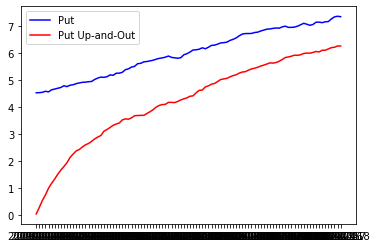

Prima de la Opción Calculada Put Up-and-Out Prima_do    2.261
Name: 2020-02-18, dtype: float64


In [58]:
# Opcion barrera
S0 = 62.57
K = 58
r = 0.0160/360
sigma = 0.2913/np.sqrt(252)

B = 60  # precio de barrera

ndays = 100
nscen = 1000
dates = pd.date_range('2019-11-11', periods = ndays).astype('str')
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = (S0*np.exp(sim_ret.cumsum()))

barrier = pd.DataFrame(B*np.ones((ndays, nscen)),index=dates)
I = (sim_closes<barrier).cumsum()>0
strike = pd.DataFrame(K*np.ones((ndays, nscen)),index=dates)
put = pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes-strike,np.zeros((ndays,nscen))).T.mean()},index=dates)

sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = (S0*np.exp(sim_ret.cumsum()))
put_uo = pd.DataFrame({'Prima_do':np.exp(-r*ndays)*(I*np.fmax(sim_closes-strike,np.zeros((ndays,nscen)))).T.mean()},index=dates)

plt.plot(put, c = 'b')
plt.plot(put_uo,c = 'r')
plt.legend(['Put','Put Up-and-Out'])
plt.show()

bar = put_uo.iloc[-1]-4
print('Prima de la Opción Calculada Put Up-and-Out', bar)


_____
<p style = "font-family: Candara; font-size:1.4em;color:#955837; text-align:center"> Conclusion </p>

_____

In [59]:
r = [[' Tipo de Opcion ', ' Prima '], ['Europea', eur], ['Americana', ame],['Asiatica', asi], ['Barrera', bar]]
print(tabulate(r, headers='firstrow', tablefmt='fancy_grid', stralign='center'))

╒════════════════════╤═══════════╕
│   Tipo de Opcion   │    Prima  │
╞════════════════════╪═══════════╡
│      Europea       │   2.83936 │
├────────────────────┼───────────┤
│     Americana      │   2.87137 │
├────────────────────┼───────────┤
│      Asiatica      │   2.5891  │
├────────────────────┼───────────┤
│      Barrera       │   2.26056 │
╘════════════════════╧═══════════╛


<p style = "font-family: Candara; font-size:1.4em;color:#955837;"> Recomendación </p>

¿Que se espera del mercado del crudo? Pues según [forbes](https://www.forbes.com/sites/daneberhart/2019/12/04/conditions-right-for-oil-market-rally-post-2020/#2a7a8fb3359f) el petroleo despuntará, pero dentro 2 a 5 años, sin embargo para el 2020 menciona: _"The outlook for 2020 does not look great. Oil prices could fall even further before seeing any meaningful recovery unless OPEC deepens its cuts"_ entonces una **opcion americana** me parece buena opcion, ya que se puede ejercer en cualquier momento, y bajo la suposición que no tenga planificado sus entradas y salidas, esta me parece decente ya que no varian tanto con respecto a los precios de las primas de las demas

## Referencias:
* https://www.ig.com/es/glosario-trading/definicion-de-opcion-put
* https://www.ig.com/es/glosario-trading/definicion-de-call
* https://finance.blogs.ie.edu/archives/2011/01/opciones-exoticas-i-asiaticas-y-lookback.php
* https://www.rankia.com/blog/cfds-igmarkets-cfd/4232011-que-son-opciones-barrera
